In [1]:
#Import Statements
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import sqlite3
from zipfile import ZipFile

import string
import regex as re

%matplotlib inline

In [2]:
color_palette = ["#86BC25"] #Set Color of PLots to Deloitte Green
sns.set_palette(palette=color_palette)

# Import Data 

In [3]:
the_numbers = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
the_numbers.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [4]:
#Run only first time to unzip the file

#Confirm with Instructors if we need to have this run
#file_name = "./zippedData/im.db.zip"
# opening the zip file in READ mode
#with ZipFile(file_name, 'r') as zip:
#    # printing all the contents of the zip file
#    #zip.printdir()
#    zip.extractall()

In [5]:
conn = sqlite3.connect('./im.db')

# Data Cleaning and EDA

In [6]:
def make_int(string):
    return int(string.replace("$","").replace(",",""))

In [7]:
the_numbers['production_budget'] = the_numbers['production_budget'].apply(lambda x: make_int(x))
the_numbers['domestic_gross'] = the_numbers['domestic_gross'].apply(lambda x: make_int(x))
the_numbers['worldwide_gross'] = the_numbers['worldwide_gross'].apply(lambda x: make_int(x))

#Creates a date time from release date
the_numbers['release_date']=(
    pd.to_datetime(the_numbers['release_date'], format='%b %d, %Y'))

#Creates a new title column
the_numbers['title']= (
    the_numbers['movie'].map(
        lambda x :''.join(filter(str.isalnum, x)).lower()))

the_numbers['days'] = the_numbers["release_date"].dt.day_name()
the_numbers['months'] = the_numbers["release_date"].dt.month_name()
the_numbers['year'] = the_numbers["release_date"].dt.year

In [8]:
the_numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
 6   title              5782 non-null   object        
 7   days               5782 non-null   object        
 8   months             5782 non-null   object        
 9   year               5782 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 451.8+ KB


# Production Budget

In [9]:
def z_score(value, mean, std):
    return (value - mean) / std

In [10]:
the_numbers_mean = the_numbers['worldwide_gross'].mean()
the_numbers_med = the_numbers['worldwide_gross'].median()
the_numbers_std = the_numbers['worldwide_gross'].std()

print(the_numbers_mean)
print(the_numbers_med)

the_numbers['z_score'] = the_numbers['worldwide_gross'].apply(lambda x: z_score(x, the_numbers_mean, the_numbers_std))

91487460.90643376
27984448.5


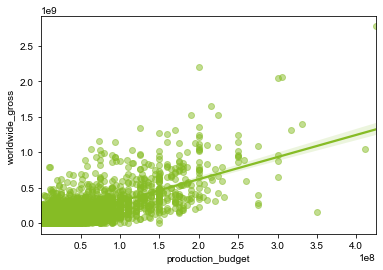

In [11]:
sns.regplot(data=the_numbers, x='production_budget', y='worldwide_gross', 
            scatter_kws={'alpha':0.5})
sns.set(rc={'figure.figsize':(15,8)})

In [12]:
gross_outliers = the_numbers[the_numbers['z_score'] > 3]
outliers_movies_lst = list(gross_outliers['movie'].values)
outliers_movies_lst[:5]

['Avatar',
 'Pirates of the Caribbean: On Stranger Tides',
 'Avengers: Age of Ultron',
 'Star Wars Ep. VIII: The Last Jedi',
 'Star Wars Ep. VII: The Force Awakens']

In [14]:
imdb_people = pd.read_sql(f"""
SELECT pr.person_id, primary_name, death_year, category, primary_title,
       original_title
FROM persons p
LEFT JOIN principals pr ON pr.person_id = p.person_id
LEFT JOIN movie_basics mb ON pr.movie_id = mb.movie_id
""", conn)

In [ ]:
#Make Sure Personnel is Alive
imdb_alive = imdb_people[imdb_people['death_year'].isnull() == True] 

#Check if Person is in List of Outliers
imdb_outliers = imdb_alive[imdb_alive['primary_title'].isin(outliers_movies_lst)]
display(imdb_outliers)

#Group Outliers Togeter to Get Counts
grouped = imdb_outliers.groupby(['category','primary_name']).size().reset_index(name='counts')
grouped.head()

In [ ]:
grouped['counts'].mean() + (3 * grouped['counts'].std())

In [ ]:
grouped3 = grouped[grouped['counts'] > 4]

In [ ]:
ax = sns.barplot(x="primary_name", y="counts", data=grouped3, color="#86BC25", order=grouped3.sort_values('counts', ascending=False).primary_name)
sns.set(rc={'figure.figsize':(15,10)})
ax.set_title("Actor Appearances")
ax.set_xlabel("Actor Name")
ax.set_ylabel("# of Occurences")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

plt.show()

# Genre

In [15]:
#Create query 
q = '''
SELECT * 
FROM movie_basics
'''
#create a DF from the IMBD sql table
imdb_movie_ratings = pd.read_sql(q, conn)
#remove na's from the original title due to low numbers
imdb_movie_ratings.dropna(subset=['original_title'], inplace = True)
imdb_movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146123 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146123 non-null  object 
 1   primary_title    146123 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146123 non-null  int64  
 4   runtime_minutes  114401 non-null  float64
 5   genres           140734 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.8+ MB


In [17]:
tn_movie_budgets = the_numbers.copy()

#create a column for movie names to merge with other DFs   tn_movie_budgets
imdb_movie_ratings['title'] = (
    imdb_movie_ratings['original_title'].map(
        lambda x :''.join(filter(str.isalnum, x)).lower()))

#sets the index on the title field for the merge
tn_movie_budgets.set_index('title', inplace=True)
imdb_movie_ratings.set_index('title', inplace=True)
imdb_movie_ratings.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
title,,,,,,
sunghursh,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
ashadkaekdin,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
theothersideofthewind,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
sabsebadasukh,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
latelenovelaerrante,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [18]:
#combine imdb and the numbers tables
rating_and_budgets = tn_movie_budgets.join(imdb_movie_ratings, how = 'inner')
rating_and_budgets.reset_index(inplace=True)
rating_and_budgets = (
    rating_and_budgets.drop_duplicates(subset='title', keep="first"))
rating_and_budgets

,title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,days,months,year,z_score,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,10cloverfieldlane,54,2016-03-11,10 Cloverfield Lane,5000000,72082999,108286422,Friday,March,2016,0.096148,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery"
1,10daysinamadhouse,48,2015-11-11,10 Days in a Madhouse,12000000,14616,14616,Wednesday,November,2015,-0.523540,tt3453052,10 Days in a Madhouse,10 Days in a Madhouse,2015,111.0,Drama
2,127hours,6,2010-11-05,127 Hours,18000000,18335230,60217171,Friday,November,2010,-0.178974,tt1542344,127 Hours,127 Hours,2010,94.0,"Adventure,Biography,Drama"
3,12rounds,37,2009-03-27,12 Rounds,20000000,12234694,17306648,Friday,March,2009,-0.424570,tt3517850,12 Rounds,12 Rounds,2017,NaN,"Action,Drama,Romance"
4,12strong,64,2018-01-19,12 Strong,35000000,45819713,71118378,Friday,January,2018,-0.116581,tt1413492,12 Strong,12 Strong,2018,130.0,"Action,Drama,History"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,zookeeper,71,2011-07-08,Zookeeper,80000000,80360866,170805525,Friday,July,2011,0.453973,tt1222817,Zookeeper,Zookeeper,2011,102.0,"Comedy,Family,Romance"
3764,zoolander2,64,2016-02-12,Zoolander 2,50000000,28848693,55348693,Friday,February,2016,-0.206838,tt1608290,Zoolander 2,Zoolander 2,2016,101.0,Comedy
3765,zoom,26,2006-08-11,Zoom,35000000,11989328,12506188,Friday,August,2006,-0.452045,tt3763866,Zoom,Zoom,2015,96.0,"Animation,Comedy,Drama"
3769,zootopia,57,2016-03-04,Zootopia,150000000,341268248,1019429616,Friday,March,2016,5.311025,tt2948356,Zootopia,Zootopia,2016,108.0,"Adventure,Animation,Comedy"


In [19]:
rating_and_budgets['genres'] =  rating_and_budgets['genres'].str.split(',')
rating_and_budgets

,title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,days,months,year,z_score,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,10cloverfieldlane,54,2016-03-11,10 Cloverfield Lane,5000000,72082999,108286422,Friday,March,2016,0.096148,tt1179933,10 Cloverfield Lane,10 Cloverfield Lane,2016,103.0,"[Drama, Horror, Mystery]"
1,10daysinamadhouse,48,2015-11-11,10 Days in a Madhouse,12000000,14616,14616,Wednesday,November,2015,-0.523540,tt3453052,10 Days in a Madhouse,10 Days in a Madhouse,2015,111.0,[Drama]
2,127hours,6,2010-11-05,127 Hours,18000000,18335230,60217171,Friday,November,2010,-0.178974,tt1542344,127 Hours,127 Hours,2010,94.0,"[Adventure, Biography, Drama]"
3,12rounds,37,2009-03-27,12 Rounds,20000000,12234694,17306648,Friday,March,2009,-0.424570,tt3517850,12 Rounds,12 Rounds,2017,NaN,"[Action, Drama, Romance]"
4,12strong,64,2018-01-19,12 Strong,35000000,45819713,71118378,Friday,January,2018,-0.116581,tt1413492,12 Strong,12 Strong,2018,130.0,"[Action, Drama, History]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,zookeeper,71,2011-07-08,Zookeeper,80000000,80360866,170805525,Friday,July,2011,0.453973,tt1222817,Zookeeper,Zookeeper,2011,102.0,"[Comedy, Family, Romance]"
3764,zoolander2,64,2016-02-12,Zoolander 2,50000000,28848693,55348693,Friday,February,2016,-0.206838,tt1608290,Zoolander 2,Zoolander 2,2016,101.0,[Comedy]
3765,zoom,26,2006-08-11,Zoom,35000000,11989328,12506188,Friday,August,2006,-0.452045,tt3763866,Zoom,Zoom,2015,96.0,"[Animation, Comedy, Drama]"
3769,zootopia,57,2016-03-04,Zootopia,150000000,341268248,1019429616,Friday,March,2016,5.311025,tt2948356,Zootopia,Zootopia,2016,108.0,"[Adventure, Animation, Comedy]"


In [20]:
#create dummy collumns to get counts and easy splits
rating_and_budgets= (
    rating_and_budgets.drop('genres',1).join(
        rating_and_budgets.genres.str.join('|').str.get_dummies()))


In [21]:
#Gets the counts or all of the genre categories
counts = rating_and_budgets.iloc[:,14:42].sum()
#Highest counts - Drama, comedy
print(counts)

start_year         4815060.0
runtime_minutes     224654.0
Action                 558.0
Adventure              428.0
Animation              131.0
Biography              189.0
Comedy                 680.0
Crime                  310.0
Documentary            196.0
Drama                 1144.0
Family                 139.0
Fantasy                156.0
History                 69.0
Horror                 285.0
Music                   70.0
Musical                 20.0
Mystery                169.0
News                     1.0
Romance                276.0
Sci-Fi                 176.0
Sport                   48.0
Thriller               392.0
War                     37.0
Western                 20.0
dtype: float64


In [22]:
#Lists for each individual statistics
#for genre in counts.index:
#    worldwide_gross_median.append(
#        rating_and_budgets[rating_and_budgets[genre] == 1]\
#            ['worldwide_gross'].median())

# Goes through each category and gets the statistic from it. 
# Then puts it in a dict with the counts

#Creates a new DF for processing
randb = rating_and_budgets.copy()
#median

worldwide_gross_median= [randb[randb[i] == 1]['worldwide_gross'].median() 
                         for i in counts.index]    
median_worldwide_gross = dict(zip(counts.index, worldwide_gross_median))

#mode
worldwide_gross_means = [randb[randb[i] == 1]['worldwide_gross'].mean() 
                         for i in counts.index]
mean_worldwide_gross = dict(zip(counts.index, worldwide_gross_means))

#count
worldwide_gross_counts = [randb[randb[i] == 1]['worldwide_gross'].count() 
                          for i in counts.index]
worldwide_gross_counts = dict(zip(counts.index, worldwide_gross_counts))

#max
worldwide_gross_max = [randb[randb[i] == 1]['worldwide_gross'].max() 
                       for i in counts.index]
worldwide_gross_max = dict(zip(counts.index, worldwide_gross_max))

#min
worldwide_gross_min = [randb[randb[i] == 1]['worldwide_gross'].min() 
                       for i in counts.index]
worldwide_gross_min = dict(zip(counts.index, worldwide_gross_min))

In [23]:
#sorts the values for data exploration
rating_and_budgets[rating_and_budgets['Music']==1].sort_values(
                                            'worldwide_gross',ascending=False)

,title,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,days,months,year,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
403,bohemianrhapsody,84,2018-11-02,Bohemian Rhapsody,55000000,216303339,894985342,Friday,November,2018,...,1,0,0,0,0,0,0,0,0,0
248,astarisborn,5,2018-10-05,A Star is Born,36000000,215288866,433449571,Friday,October,2018,...,1,0,0,0,1,0,0,0,0,0
1583,lalaland,92,2016-12-09,La La Land,20000000,151101803,426351163,Friday,December,2016,...,1,0,0,0,0,0,0,0,0,0
2101,pitchperfect2,14,2015-05-15,Pitch Perfect 2,29000000,184296230,287625468,Friday,May,2015,...,1,0,0,0,0,0,0,0,0,0
2102,pitchperfect3,58,2017-12-22,Pitch Perfect 3,45000000,104897530,185736412,Friday,December,2017,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,alongtheroadside,91,2015-03-24,Along the Roadside,250000,0,3234,Tuesday,March,2015,...,1,0,0,0,1,0,0,0,0,0
162,americanhero,3,2015-12-11,American Hero,1000000,0,26,Friday,December,2015,...,1,0,0,0,0,0,0,0,0,0
3220,theresaisamother,40,2015-09-29,Theresa Is a Mother,200000,0,0,Tuesday,September,2015,...,1,0,0,0,0,0,0,0,0,0
2548,steelspirit,58,2003-12-01,Steel Spirit,20000,0,0,Monday,December,2003,...,1,0,0,0,0,0,0,0,0,0


In [24]:
#creates dataframe to highlight the stats
movie_stats = pd.DataFrame(
    zip(median_worldwide_gross.values(), 
        mean_worldwide_gross.values(), 
        worldwide_gross_counts.values(), 
        worldwide_gross_max.values(),
        worldwide_gross_min.values()),
    median_worldwide_gross.keys(),
        ['Medians','Means','Counts','Max','Min'])

In [25]:
#sorts the DF by median
movie_stats.sort_values('Medians', ascending=False)

,Medians,Means,Counts,Max,Min
Animation,197578586.0,3.006570e+08,131,1.242521e+09,0.0
Adventure,182667975.0,3.034551e+08,428,2.208208e+09,0.0
Action,87359119.5,1.993443e+08,558,2.048134e+09,0.0
Fantasy,84720721.5,2.078764e+08,156,1.259200e+09,0.0
Sci-Fi,79476525.5,2.553969e+08,176,2.048134e+09,0.0
News,57293371.0,5.729337e+07,1,5.729337e+07,57293371.0
Comedy,46055025.0,1.122968e+08,680,1.160336e+09,0.0
Family,42174545.0,1.401701e+08,139,1.259200e+09,0.0
Mystery,34246770.0,7.642743e+07,169,5.864643e+08,0.0
Musical,30128794.5,1.309215e+08,20,1.259200e+09,0.0


C:\Users\jniegocki\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jniegocki\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='worldwide_gross', ylabel='Density'>

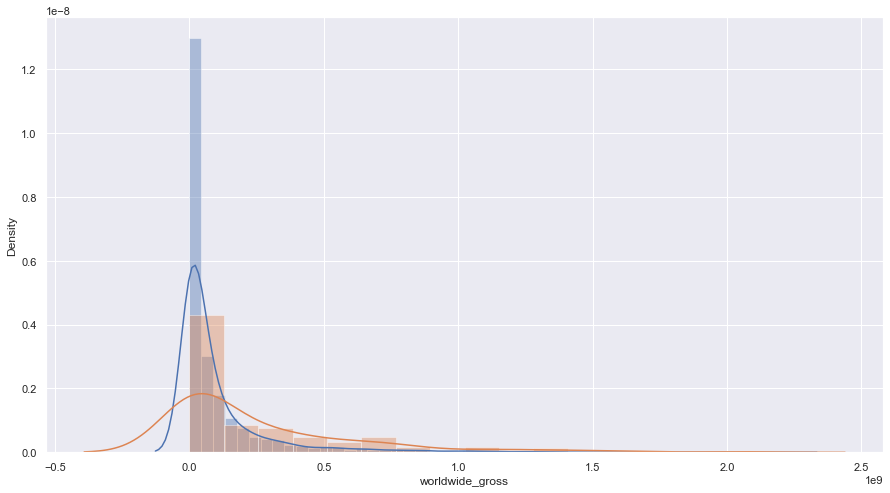

In [26]:
#plot the distribution of overall and the category
sns.distplot(rating_and_budgets['worldwide_gross'])
sns.distplot(
    rating_and_budgets[rating_and_budgets['Sci-Fi']==1]['worldwide_gross'])

In [27]:
#Creates two DFs, one with Sci-Fi and one without
animated_movies = rating_and_budgets[rating_and_budgets['Sci-Fi'] == 1]
not_animated_movies = rating_and_budgets[rating_and_budgets['Sci-Fi'] == 0]

In [28]:
#Runs a ttest
stats.ttest_ind(animated_movies['worldwide_gross'], 
                not_animated_movies['worldwide_gross'])

Ttest_indResult(statistic=10.570233558029575, pvalue=1.48717395752926e-25)

In [29]:
#Does the above tests for every genre
ttest_res = []
for genre in counts.index:
    genre_movie = rating_and_budgets[rating_and_budgets[genre] == 1]
    not_genre_movies = rating_and_budgets[rating_and_budgets[genre] == 0]
    ttest_res.append(stats.ttest_ind(genre_movie['worldwide_gross'], 
                                     not_genre_movies['worldwide_gross']))
    
ttest_res

#Warning happens due to th T-test being ran on news, which has 2 samples

C:\Users\jniegocki\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\jniegocki\Anaconda3\envs\learn-env\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\jniegocki\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


[Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=13.107346510910421, pvalue=5.900928213424494e-38),
 Ttest_indResult(statistic=25.48977638395868, pvalue=5.633579330967527e-127),
 Ttest_indResult(statistic=11.819691277138588, pvalue=2.2692702400680073e-31),
 Ttest_indResult(statistic=-2.7966397138567887, pvalue=0.005205041694229788),
 Ttest_indResult(statistic=1.047405756099582, pvalue=0.29501843255875276),
 Ttest_indResult(statistic=-4.057785417529457, pvalue=5.1131046465999955e-05),
 Ttest_indResult(statistic=-4.2692549623054825, pvalue=2.0378770368998445e-05),
 Ttest_indResult(statistic=-10.45618829039637, pvalue=4.725721936090204e-25),
 Ttest_indResult(statistic=2.1078758810063034, pvalue=0.0351456427411942),
 Ttest_indResult(statistic=6.674638667694225, pvalue=3.0707557723409656e-11),
 Ttest_indResult(statistic=-2.165103541533435, pvalue=0.030478460461883773),
 Ttest_indResult(statistic=-4.632481554676081, pvalue=3

In [30]:
#Creates a DF for all the t-statistics and pvals
tscores = pd.DataFrame(dict(zip(counts.index, ttest_res)), 
                       ["Statistic", "Pvalue"]).T

In [31]:
#sorts the df by statistic
tscores.sort_values('Statistic')

,Statistic,Pvalue
Drama,-10.456188,4.725722e-25
Horror,-4.632482,3.807083e-06
Documentary,-4.269255,2.037877e-05
Romance,-4.233917,2.383419e-05
Crime,-4.057785,5.113105e-05
Biography,-2.796640,5.205042e-03
Thriller,-2.656510,7.947929e-03
History,-2.165104,3.047846e-02
Mystery,-1.962300,4.984347e-02
Music,-1.802306,7.162329e-02


In [32]:
#len(counts.index)
rating_and_budgets['worldwide_gross'].median()

30063805.0

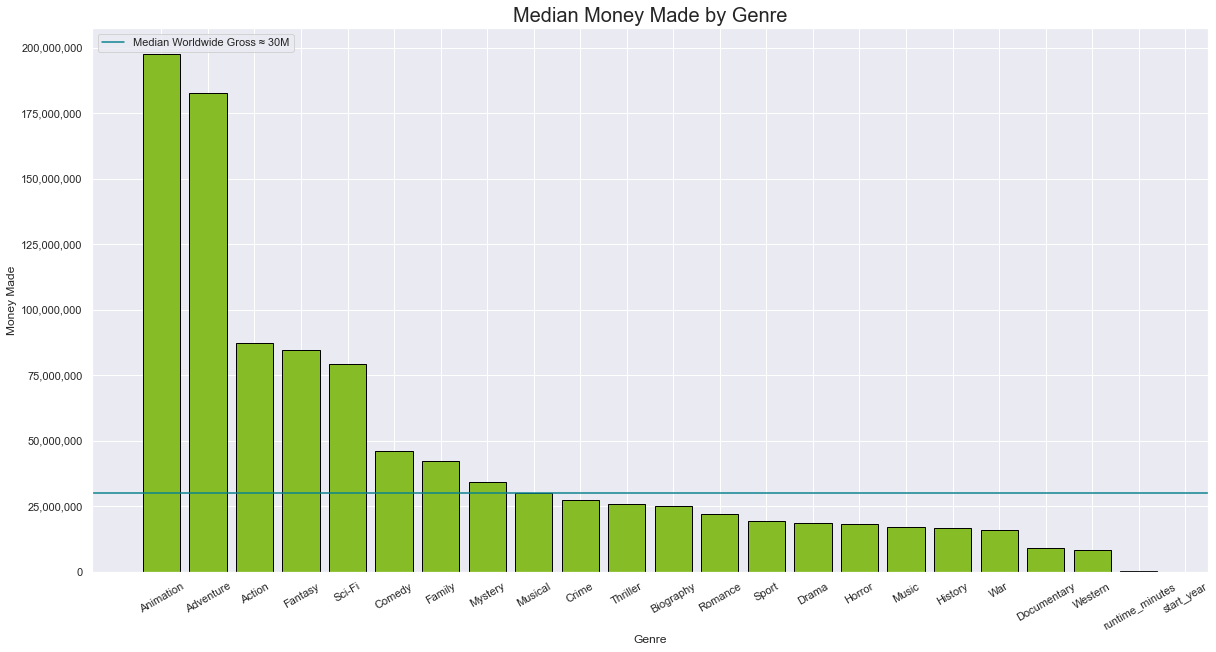

In [33]:
#Sets the theme to seaborn
sns.set_theme()

#Remove News as there is only 1 sample
cleaned_stats = movie_stats.drop(
    index='News').sort_values('Medians', ascending=False)

#Create figure
fig, ax = plt.subplots(figsize=(20,10))

#Create a bar plot for all of the medians for each genre
ax.bar(range(0,len(cleaned_stats['Medians'])), 
       list(cleaned_stats['Medians']), color = '#86BC25',edgecolor = "black")

#Creates the xticks
ax.set_xticks(range(0,len(cleaned_stats['Medians'])))
ax.set_xticklabels(list(cleaned_stats.index.values), rotation = 30)

#Sets the tables and the titles
ax.set_xlabel('Genre')
ax.set_ylabel('Money Made')
ax.set_title('Median Money Made by Genre', fontsize=20)
#Cleans up the formatting of
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

#plot median income line
plt.axhline(y = rating_and_budgets['worldwide_gross'].median(), 
            color = '#0D8390', linestyle = '-', 
            label = 'Median Worldwide Gross ≈ 30M')
#Shows the legend
ax.legend()

plt.show()